In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gsw
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from datetime import datetime
from IPython.display import display



In [2]:
'''
Binary prediction skill (“bloom” or “no bloom”) is
evaluated by how well bloom predictions (5% largest predicted values)
correspond to bloom observations (5%largest observed values)
Input: Series of observed chlorophyll-a, series of predicted chlorophyll-1
Output: Arrray containing [Accuracy, True Positive Rate, False Positive Rate, True Negative Rate, False Negative Rate]
'''
def bloom_binary_prediction(obs,pred):
    obs_bloom_95 = np.percentile(obs, 95)
    pred_bloom_95 = np.percentile(pred, 95)
    obs_blooms = obs > obs_bloom_95
    pred_blooms = pred > pred_bloom_95
    Accuracy = 1 - (obs_blooms ^ pred_blooms).mean()
    True_pos = (obs_blooms & pred_blooms).sum() / obs_blooms.sum()
    False_pos = ((~obs_blooms) & pred_blooms).sum() / (~obs_blooms).sum()
    True_neg = ((~obs_blooms) & (~pred_blooms)).sum() / (~obs_blooms).sum()
    False_neg = (obs_blooms & (~pred_blooms)).sum() / obs_blooms.sum()
    
    return [Accuracy, True_pos, False_pos, True_neg, False_neg]


Chloro 95th percntile: 8.111999999999988


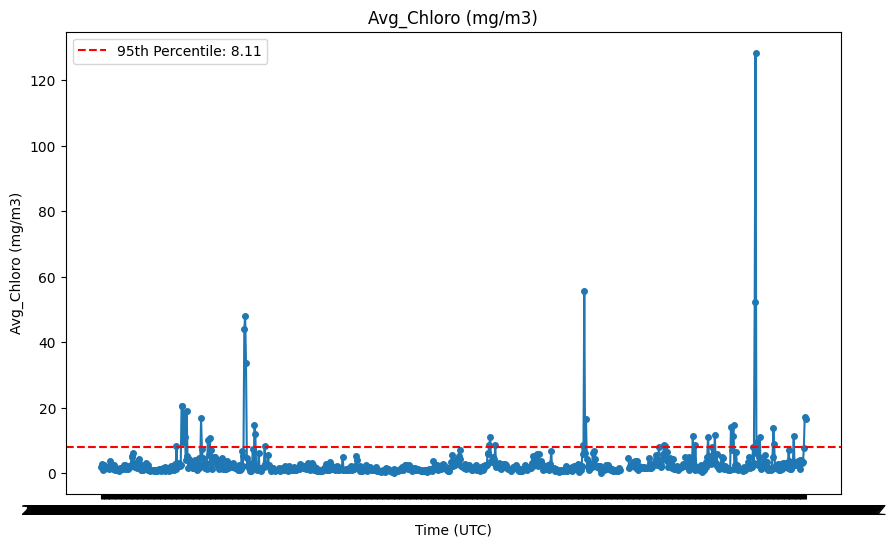

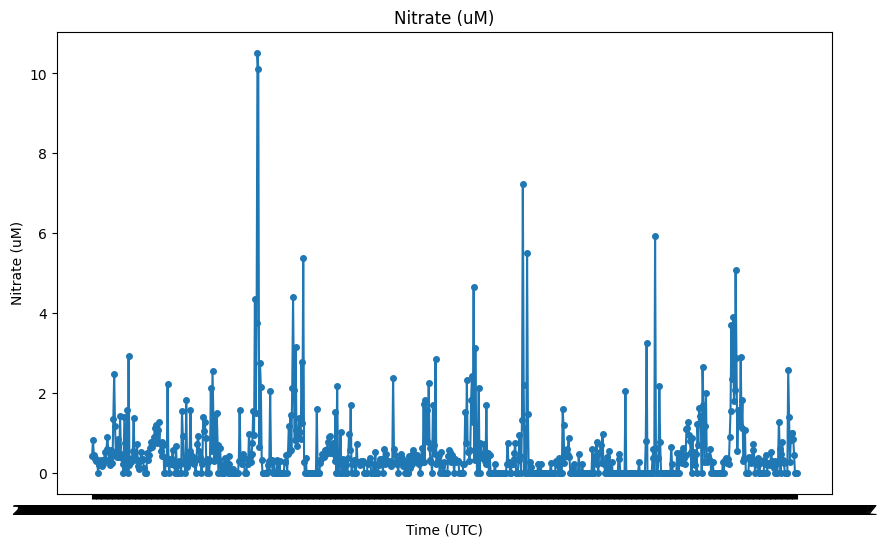

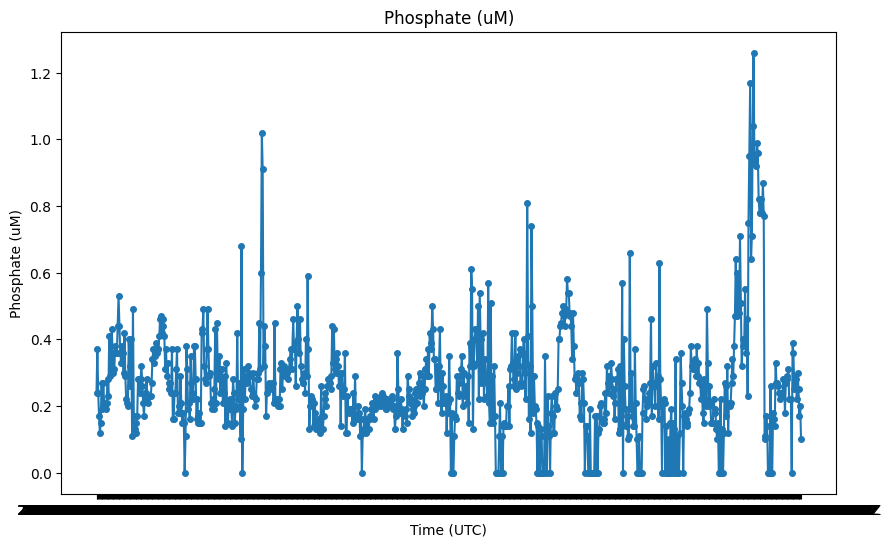

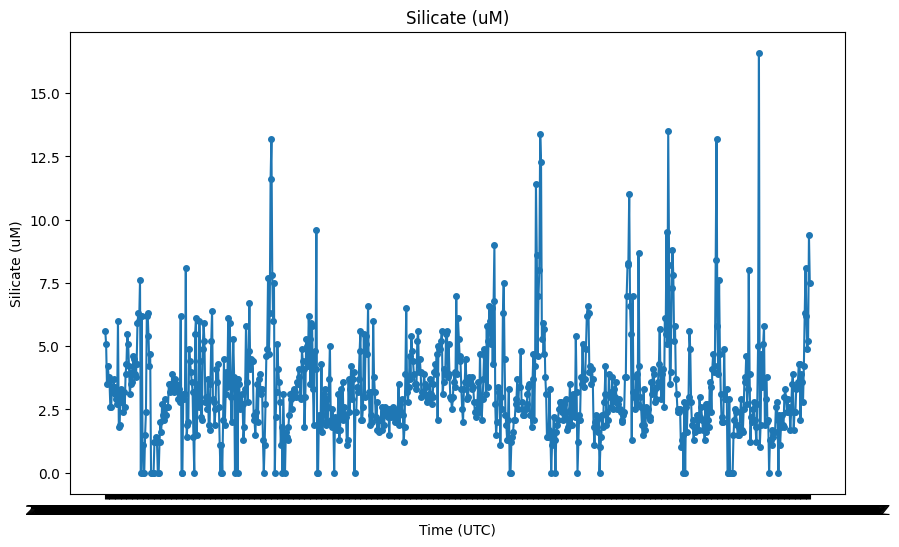

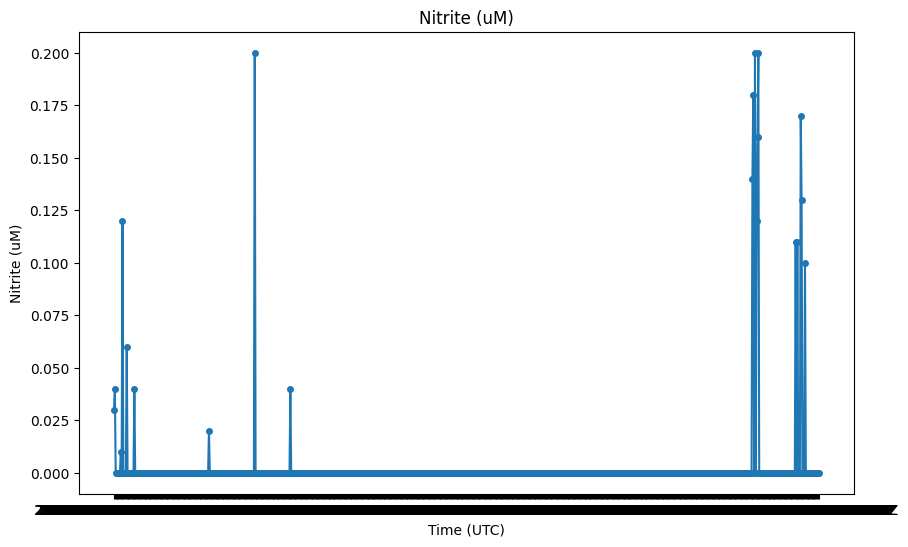

In [3]:
pier_data = pd.read_csv('Data/sccoos_HAB_SIO.csv')

#pier_data[pier_data['Lingulodinium_polyedra (cells/L)'] != 'NaN']
pier_data_paper = pier_data[['time (UTC)','Avg_Chloro (mg/m3)','Nitrate (uM)','Phosphate (uM)', 'Silicate (uM)','Nitrite (uM)','Temp (degree_C)','Salinity']]
pier_data_paper = pier_data_paper.dropna(subset=['Nitrate (uM)'])

#for algal bloom
chloro_95th = np.percentile(pier_data_paper['Avg_Chloro (mg/m3)'].dropna(), 95)
print('Chloro 95th percntile: ' + str(chloro_95th))

# plots of filtered out columns
columns = ['Avg_Chloro (mg/m3)', 'Nitrate (uM)', 'Phosphate (uM)', 'Silicate (uM)', 'Nitrite (uM)']
for col in columns:
    plt.figure(figsize=(10, 6))
    plt.plot(pier_data_paper['time (UTC)'], pier_data_paper[col], marker='o', linestyle='-', markersize=4)
    plt.title(col)
    plt.xlabel('Time (UTC)')
    plt.ylabel(col)
    if col == 'Avg_Chloro (mg/m3)':
        plt.axhline(y=chloro_95th, color='r', linestyle='--', label=f'95th Percentile: {chloro_95th:.2f}')
        plt.legend()
    



In [4]:
NA_per_col = pier_data.isna().sum()
NA_per_col

Location_Code                                       0
latitude (degrees_north)                            0
longitude (degrees_east)                            0
depth (m)                                         858
SampleID                                            0
time (UTC)                                          0
Temp (degree_C)                                     0
Air_Temp (degree_C)                               858
Salinity                                          858
Chl_Volume_Filtered (mL)                            9
Chl1 (mg/m3)                                       10
Chl2 (mg/m3)                                       11
Avg_Chloro (mg/m3)                                 10
Phaeo1 (mg/m3)                                     10
Phaeo2 (mg/m3)                                     11
Avg_Phaeo (mg/m3)                                  10
Phosphate (uM)                                     26
Silicate (uM)                                      26
Nitrite (uM)                

In [5]:
missing_times_for_chloro = pier_data.loc[pier_data['Lingulodinium_polyedra (cells/L)'].isna(), 'time (UTC)']
print(missing_times_for_chloro)

0      2008-06-30T15:00:00Z
1      2008-07-07T15:00:00Z
2      2008-07-14T14:54:00Z
3      2008-07-21T14:50:00Z
4      2008-07-28T16:44:00Z
               ...         
846    2024-09-16T19:49:00Z
847    2024-09-23T19:25:00Z
848    2024-09-30T19:39:00Z
849    2024-10-07T19:23:00Z
850    2024-10-14T17:58:00Z
Name: time (UTC), Length: 587, dtype: object


In [6]:
def format_time(time):
    if pd.notna(time):  # Check if time is not NaN
        time = int(time)
        hours = time // 100
        minutes = time % 100
        return f"{hours:02d}:{minutes:02d}:00"
    else:
        return "00:00:00"
    
#Append temperatures
temp_data = pd.read_csv('Data/Temperatures.csv')
temp_data['ISO_TIME'] = (
    temp_data['YEAR'].astype(str) + "-" +
    temp_data['MONTH'].astype(str).str.zfill(2) + "-" +
    temp_data['DAY'].astype(str).str.zfill(2) + "T" +
    temp_data['TIME_PST'].apply(format_time) + "Z"
)

temp_data = temp_data[['SURF_TEMP_C','BOT_TEMP_C','ISO_TIME']]
pier_data_paper['Date'] = pd.to_datetime(pier_data_paper['time (UTC)']).dt.date
temp_data['Date'] = pd.to_datetime(temp_data['ISO_TIME']).dt.date

paper_and_temp = pd.merge(pier_data_paper, temp_data, on='Date', how='inner') 
paper_and_temp = paper_and_temp.drop(columns=['ISO_TIME'])

#Append Salinity 
sal_data = pd.read_csv('Data/Salinity.csv')
sal_data['ISO_TIME'] = (
    sal_data['YEAR'].astype(str) + "-" +
    sal_data['MONTH'].astype(str).str.zfill(2) + "-" +
    sal_data['DAY'].astype(str).str.zfill(2) + "T" +
    sal_data['TIME_PST'].apply(format_time) + "Z"
)
sal_data = sal_data[['SURF_SAL_PSU','BOT_SAL_PSU','ISO_TIME']]

sal_data['Date'] = pd.to_datetime(sal_data['ISO_TIME']).dt.date

paper_data = pd.merge(paper_and_temp, sal_data, on='Date', how='inner')
paper_data = paper_data.drop(columns=['ISO_TIME', 'Salinity'])

#Calculate an append Density
paper_data['SURF_DENS_kgm3'] = gsw.density.rho(SA=paper_data['SURF_SAL_PSU'].values, CT=paper_data['SURF_TEMP_C'].values, p=(0)) #surface taken at 0m
paper_data['BOT_DENS_kgm3'] = gsw.density.rho(SA=paper_data['BOT_SAL_PSU'].values, CT=paper_data['BOT_TEMP_C'].values, p=(5)) #surface taken at 5m

#Account for Bottom Temperature Anomaly
# QUESTION: WHAT IS THE BOTTOM TEMPERATURE ANOMALY
def bottom_temp_anomaly(bot_temp):
    T_s = paper_data['SURF_TEMP_C'].mean()
    if bot_temp - T_s - 0.8 > 0:
        return 0
    else:
        return bot_temp

#Final calculations as seen in paper
paper_data['AVG_TEMP_C'] = (paper_data['SURF_TEMP_C'] + paper_data['BOT_TEMP_C'].apply(bottom_temp_anomaly))/2
paper_data['AVG_SAL_PSU'] = (paper_data['SURF_SAL_PSU'] + paper_data['BOT_SAL_PSU'])/2
paper_data['AVG_DENS_kgm3'] = (paper_data['SURF_DENS_kgm3'] + paper_data['BOT_DENS_kgm3'])/2

paper_data = paper_data.drop(columns=['Temp (degree_C)','Date'])
#### TODO V-wind AND RAINFALL ####

In [18]:
paper_data

,time (UTC),Avg_Chloro (mg/m3),Nitrate (uM),Phosphate (uM),Silicate (uM),Nitrite (uM),SURF_TEMP_C,BOT_TEMP_C,SURF_SAL_PSU,BOT_SAL_PSU,SURF_DENS_kgm3,BOT_DENS_kgm3,AVG_TEMP_C,AVG_SAL_PSU,AVG_DENS_kgm3
0,0,1.82,0.43,0.24,5.6,0.03,20.3,15.9,33.77,33.62,1023.638094,1024.620655,18.10,33.695,1024.129374
1,7,2.71,0.83,0.37,5.1,0.04,17.8,16.9,33.66,33.62,1024.186379,1024.391719,17.35,33.640,1024.289049
2,13,0.99,0.45,0.24,3.5,0.00,22.2,18.3,33.74,33.58,1023.100557,1024.026040,20.25,33.660,1023.563298
3,20,1.23,0.34,0.17,4.2,0.00,19.8,19.4,33.68,33.62,1023.701088,1023.780535,9.90,33.650,1023.740812
4,28,2.41,0.29,0.12,3.8,0.00,22.5,22.5,33.73,33.69,1023.009067,1023.000725,11.25,33.710,1023.004896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,5789,3.22,0.85,0.30,6.2,0.00,17.4,17.4,33.48,33.46,1024.146195,1024.152950,17.40,33.470,1024.149572
828,5796,3.39,0.45,0.25,4.9,0.00,17.9,17.9,33.48,33.47,1024.026335,1024.040616,17.90,33.475,1024.033476
829,5803,7.82,0.00,0.17,5.2,0.00,18.3,16.4,33.54,33.55,1023.974093,1024.454252,17.35,33.545,1024.214172
830,5811,17.30,0.00,0.20,9.4,0.00,18.0,17.4,33.64,33.61,1024.122823,1024.266323,17.70,33.625,1024.194573


In [7]:
na_per_column = paper_data.isna().sum()
na_per_column

time (UTC)             0
Avg_Chloro (mg/m3)    10
Nitrate (uM)           0
Phosphate (uM)         0
Silicate (uM)          0
Nitrite (uM)           0
SURF_TEMP_C           51
BOT_TEMP_C            95
SURF_SAL_PSU          51
BOT_SAL_PSU           92
SURF_DENS_kgm3        53
BOT_DENS_kgm3         95
AVG_TEMP_C            96
AVG_SAL_PSU           95
AVG_DENS_kgm3         98
dtype: int64

In [8]:
missing_times_for_chloro = paper_data.loc[paper_data['Avg_Chloro (mg/m3)'].isna(), 'time (UTC)']
print(missing_times_for_chloro)

303    2014-04-21T19:05:00Z
613    2020-03-30T18:40:00Z
614    2020-04-07T20:30:00Z
615    2020-04-13T18:40:00Z
616    2020-04-20T19:26:00Z
617    2020-04-27T18:17:00Z
618    2020-05-04T19:35:00Z
619    2020-05-11T19:50:00Z
620    2020-05-18T19:35:00Z
621    2020-05-26T19:30:00Z
Name: time (UTC), dtype: object


In [9]:
missing_times_for_temp = paper_data.loc[paper_data['AVG_TEMP_C'].isna(), 'time (UTC)']
#display(missing_times_for_temp.to_frame().style.set_sticky())
missing_times_for_temp

13     2008-09-29T15:44:00Z
24     2008-12-15T16:40:00Z
30     2009-01-26T17:00:00Z
32     2009-02-09T17:15:00Z
33     2009-02-16T17:09:00Z
               ...         
770    2023-04-03T18:38:00Z
809    2024-01-03T20:49:00Z
812    2024-01-22T21:56:00Z
814    2024-02-05T21:01:00Z
816    2024-02-20T22:10:00Z
Name: time (UTC), Length: 96, dtype: object

In [10]:
missing_times_for_dens = paper_data.loc[paper_data['AVG_DENS_kgm3'].isna(), 'time (UTC)']
#display(missing_times_for_dens.to_frame().style.set_sticky())
missing_times_for_dens

13     2008-09-29T15:44:00Z
24     2008-12-15T16:40:00Z
30     2009-01-26T17:00:00Z
32     2009-02-09T17:15:00Z
33     2009-02-16T17:09:00Z
               ...         
770    2023-04-03T18:38:00Z
809    2024-01-03T20:49:00Z
812    2024-01-22T21:56:00Z
814    2024-02-05T21:01:00Z
816    2024-02-20T22:10:00Z
Name: time (UTC), Length: 98, dtype: object

In [11]:
missing_times_for_sal = paper_data.loc[paper_data['AVG_SAL_PSU'].isna(), 'time (UTC)']
#display(missing_times_for_sal.to_frame().style.set_sticky())
missing_times_for_sal

13     2008-09-29T15:44:00Z
24     2008-12-15T16:40:00Z
30     2009-01-26T17:00:00Z
32     2009-02-09T17:15:00Z
33     2009-02-16T17:09:00Z
               ...         
770    2023-04-03T18:38:00Z
809    2024-01-03T20:49:00Z
812    2024-01-22T21:56:00Z
814    2024-02-05T21:01:00Z
816    2024-02-20T22:10:00Z
Name: time (UTC), Length: 95, dtype: object

In [12]:
paper_data.to_csv('Data/base_data_w_UTC.csv', index=False)

In [13]:
#Convert dates

min_day = paper_data['time (UTC)'].min() 
def convert_dates(day):
    date1 = datetime.strptime(day, '%Y-%m-%dT%H:%M:%SZ')
    date2 = datetime.strptime(min_day , '%Y-%m-%dT%H:%M:%SZ')
    difference = date1 - date2
    return difference.days
convert_dates(paper_data['time (UTC)'].max())
paper_data['time (UTC)'] = paper_data.get('time (UTC)').apply(convert_dates)
paper_data.to_csv('Data/data_w_gaps.csv', index=False)
paper_data

,time (UTC),Avg_Chloro (mg/m3),Nitrate (uM),Phosphate (uM),Silicate (uM),Nitrite (uM),SURF_TEMP_C,BOT_TEMP_C,SURF_SAL_PSU,BOT_SAL_PSU,SURF_DENS_kgm3,BOT_DENS_kgm3,AVG_TEMP_C,AVG_SAL_PSU,AVG_DENS_kgm3
0,0,1.82,0.43,0.24,5.6,0.03,20.3,15.9,33.77,33.62,1023.638094,1024.620655,18.10,33.695,1024.129374
1,7,2.71,0.83,0.37,5.1,0.04,17.8,16.9,33.66,33.62,1024.186379,1024.391719,17.35,33.640,1024.289049
2,13,0.99,0.45,0.24,3.5,0.00,22.2,18.3,33.74,33.58,1023.100557,1024.026040,20.25,33.660,1023.563298
3,20,1.23,0.34,0.17,4.2,0.00,19.8,19.4,33.68,33.62,1023.701088,1023.780535,9.90,33.650,1023.740812
4,28,2.41,0.29,0.12,3.8,0.00,22.5,22.5,33.73,33.69,1023.009067,1023.000725,11.25,33.710,1023.004896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,5789,3.22,0.85,0.30,6.2,0.00,17.4,17.4,33.48,33.46,1024.146195,1024.152950,17.40,33.470,1024.149572
828,5796,3.39,0.45,0.25,4.9,0.00,17.9,17.9,33.48,33.47,1024.026335,1024.040616,17.90,33.475,1024.033476
829,5803,7.82,0.00,0.17,5.2,0.00,18.3,16.4,33.54,33.55,1023.974093,1024.454252,17.35,33.545,1024.214172
830,5811,17.30,0.00,0.20,9.4,0.00,18.0,17.4,33.64,33.61,1024.122823,1024.266323,17.70,33.625,1024.194573


In [14]:
#Output current dataframe
class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
        X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

        return (X_filled_forward + X_filled_backward) / 2
    
#forceasting to fill gaps 
    
impute_pipeline = Pipeline([
    ('imputer', ForwardBackwardImputer()), 
])

impute_pipeline.fit(paper_data)
paper_data
#difference in temperatures would be another feature to add
#rainfall measured airport 

,time (UTC),Avg_Chloro (mg/m3),Nitrate (uM),Phosphate (uM),Silicate (uM),Nitrite (uM),SURF_TEMP_C,BOT_TEMP_C,SURF_SAL_PSU,BOT_SAL_PSU,SURF_DENS_kgm3,BOT_DENS_kgm3,AVG_TEMP_C,AVG_SAL_PSU,AVG_DENS_kgm3
0,0,1.82,0.43,0.24,5.6,0.03,20.3,15.9,33.77,33.62,1023.638094,1024.620655,18.10,33.695,1024.129374
1,7,2.71,0.83,0.37,5.1,0.04,17.8,16.9,33.66,33.62,1024.186379,1024.391719,17.35,33.640,1024.289049
2,13,0.99,0.45,0.24,3.5,0.00,22.2,18.3,33.74,33.58,1023.100557,1024.026040,20.25,33.660,1023.563298
3,20,1.23,0.34,0.17,4.2,0.00,19.8,19.4,33.68,33.62,1023.701088,1023.780535,9.90,33.650,1023.740812
4,28,2.41,0.29,0.12,3.8,0.00,22.5,22.5,33.73,33.69,1023.009067,1023.000725,11.25,33.710,1023.004896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827,5789,3.22,0.85,0.30,6.2,0.00,17.4,17.4,33.48,33.46,1024.146195,1024.152950,17.40,33.470,1024.149572
828,5796,3.39,0.45,0.25,4.9,0.00,17.9,17.9,33.48,33.47,1024.026335,1024.040616,17.90,33.475,1024.033476
829,5803,7.82,0.00,0.17,5.2,0.00,18.3,16.4,33.54,33.55,1023.974093,1024.454252,17.35,33.545,1024.214172
830,5811,17.30,0.00,0.20,9.4,0.00,18.0,17.4,33.64,33.61,1024.122823,1024.266323,17.70,33.625,1024.194573


In [15]:
#Build basic linear regression model as sanity check
# Custom impute missing values with the average of the value in front and behind of it 
class ForwardBackwardImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
        X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')

        return (X_filled_forward + X_filled_backward) / 2


Imputer = ForwardBackwardImputer()
paper_data = paper_data.apply(pd.to_numeric, errors='coerce')
Imputer.fit(paper_data)
paper_data_to_print = Imputer.transform(paper_data)
paper_data_to_print = paper_data_to_print.rename(columns={'Avg_Chloro (mg/m3)': 'Avg_Chloro', 'Nitrate (uM)': 'Nitrate', 'Phosphate (uM)':'Phosphate', 'Silicate (uM)':'Silicate','Nitrite (uM)':'Nitrite'})
print(paper_data_to_print)
paper_data_to_print.to_csv('Data/cleaned_data.csv', index=False)


X = paper_data.drop(columns=['time (UTC)','Avg_Chloro (mg/m3)','SURF_TEMP_C','BOT_TEMP_C','SURF_SAL_PSU','BOT_SAL_PSU','SURF_DENS_kgm3','BOT_DENS_kgm3'])  # Independent variable
y = paper_data['Avg_Chloro (mg/m3)']    # Dependent variable
y = Imputer.transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regression_pipeline = Pipeline([
    ('imputer', ForwardBackwardImputer()),  # Imputation step
    ('regressor', LinearRegression())      # Linear regression model
])


regression_pipeline.fit(X_train, y_train)

y_pred = regression_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

bloom_binary_prediction(y_test, y_pred)

     time (UTC)  Avg_Chloro  Nitrate  Phosphate  Silicate  Nitrite  \
0           0.0        1.82     0.43       0.24       5.6     0.03   
1           7.0        2.71     0.83       0.37       5.1     0.04   
2          13.0        0.99     0.45       0.24       3.5     0.00   
3          20.0        1.23     0.34       0.17       4.2     0.00   
4          28.0        2.41     0.29       0.12       3.8     0.00   
..          ...         ...      ...        ...       ...      ...   
827      5789.0        3.22     0.85       0.30       6.2     0.00   
828      5796.0        3.39     0.45       0.25       4.9     0.00   
829      5803.0        7.82     0.00       0.17       5.2     0.00   
830      5811.0       17.30     0.00       0.20       9.4     0.00   
831      5817.0       16.71     0.00       0.10       7.5     0.00   

     SURF_TEMP_C  BOT_TEMP_C  SURF_SAL_PSU  BOT_SAL_PSU  SURF_DENS_kgm3  \
0           20.3        15.9         33.77        33.62     1023.638094   
1        

/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_29464/4233386626.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_29464/4233386626.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_backward = X.fillna(method='bfill').fillna(method='ffill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_29464/4233386626.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_filled_forward = X.fillna(method='ffill').fillna(method='bfill')
/var/folders/5y/74w_zv855875xvjtmhp4g1xw0000gn/T/ipykernel_29464/4233386626.py:12: FutureWarning: Series.fillna with 'method' is deprecate

[0.9401197604790419,
 0.4444444444444444,
 0.03164556962025317,
 0.9683544303797469,
 0.5555555555555556]

In [16]:
3 + np.NaN

nan

In [17]:
#PYEDM